# Model using Keras

# 1. Thiết lập ban đầu và import các thư viện cần thiết:

In [1]:
input_steps = 100
output_steps = 5 # Missing 5% data.
# Thư mục chứa các file .mat
file_path = r"D:\NCS\RESEARCH\Code_Scopus2\Code_RachMieu1\RachMieu1_Data\SETUP4.mat"
#file_path = r"D:\USERS\tranthehiep\RM1Bridge\RachMieu1_Data\SETUP4.mat"
select_sensor = 1 # 1, 2, 3

# Số lượng mẫu mong muốn cho cả 3 tập Train, Validate, Test: 10.000 samples.
# num_samples = T - (input_length + output_length) + 1
# T = num_samples + (input_length + output_length) - 1
design_samples = 10000
step_start = 14000
step_finish = step_start + design_samples + (input_steps + output_steps) - 1

# Xóa toàn bộ kết quả trước khi chạy lại
import os
os.system('cls' if os.name == 'nt' else 'clear')

# Hiển thị tất cả các kết quả trong một ô lệnh, thay vì chỉ hiển thị kết quả cuối cùng
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input
from sklearn.preprocessing import MinMaxScaler
import pickle # Để lưu history

# 2. Đọc dữ liệu dao động từ file

In [2]:
import scipy.io
import numpy as np
import os

# Đọc file .mat
data = scipy.io.loadmat(file_path)

# Danh sách các key có dạng 'UntitledXXZ'
keys_to_extract = [key for key in data.keys() if key.startswith("Untitled") and key.endswith("Z")]

# Danh sách chứa dữ liệu số từ các key
extracted_arrays = []

# Lặp qua từng key để lấy dữ liệu số từ trường 'Data'
for key in keys_to_extract:
    raw_value = data[key][0, 0]  # Lấy phần tử đầu tiên
    if isinstance(raw_value, np.void) and 'Data' in raw_value.dtype.names:
        numerical_array = raw_value['Data']  # Lấy dữ liệu từ trường 'Data'
        if isinstance(numerical_array, np.ndarray) and numerical_array.ndim == 2:
            extracted_arrays.append(numerical_array.flatten())  # Chuyển thành 1D để xử lý

# Chuyển danh sách thành mảng 2D (nếu có dữ liệu)
if extracted_arrays:
    final_array = np.column_stack(extracted_arrays)  # Ghép thành ma trận 2D (hàng x cột)
    print("Kích thước của dữ liệu của mảng:", final_array.shape )
else:
    print(f"Không có dữ liệu hợp lệ trong file: {file_path}")

print("Hoàn tất xử lý và lưu tất cả file")

Kích thước của dữ liệu của mảng: (1058291, 4)
Hoàn tất xử lý và lưu tất cả file


# 3. Chuẩn bị dữ liệu cho mô hình

Dữ liệu gốc: (4, 1058291)


Text(0.5, 1.0, 'Sensor 1')

Text(0.5, 1.0, 'Sensor 2')

Text(0.5, 1.0, 'Sensor 3')

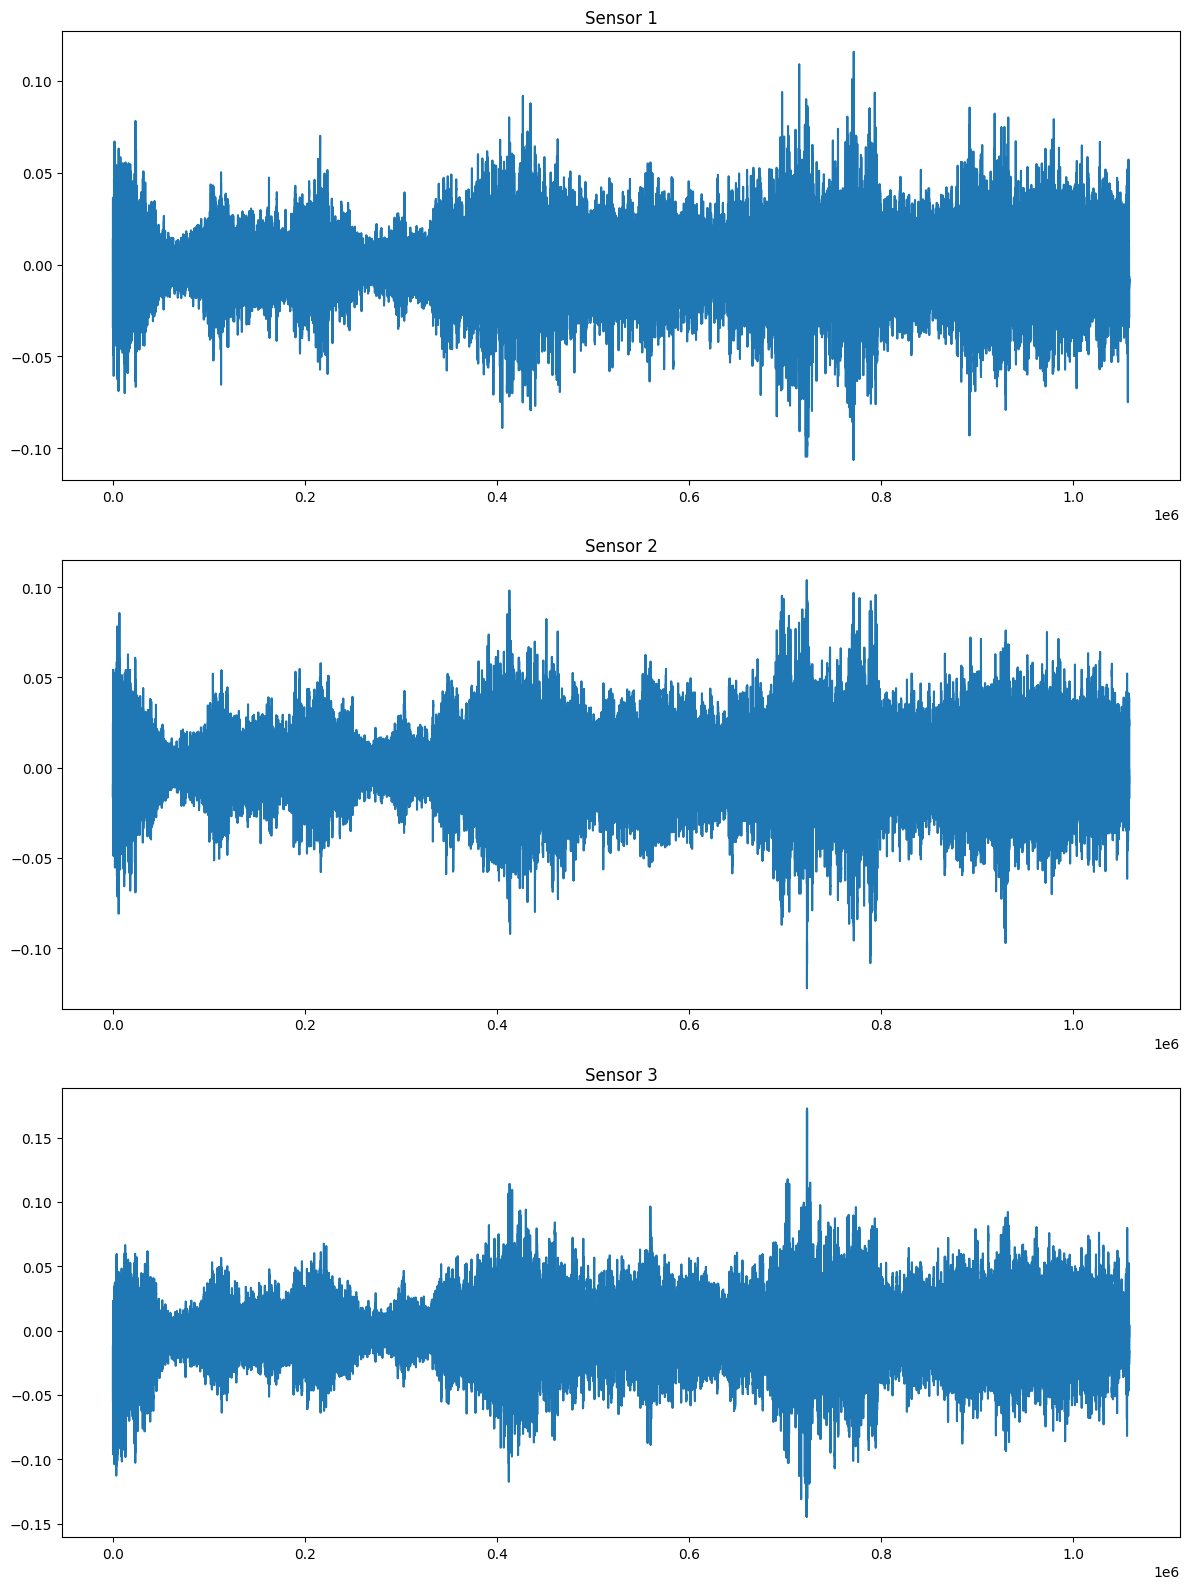

(4, 300000)
Sau khi slice: (4, 10104)


Text(0.5, 1.0, 'Sensor 1')

Text(0.5, 1.0, 'Sensor 2')

Text(0.5, 1.0, 'Sensor 3')

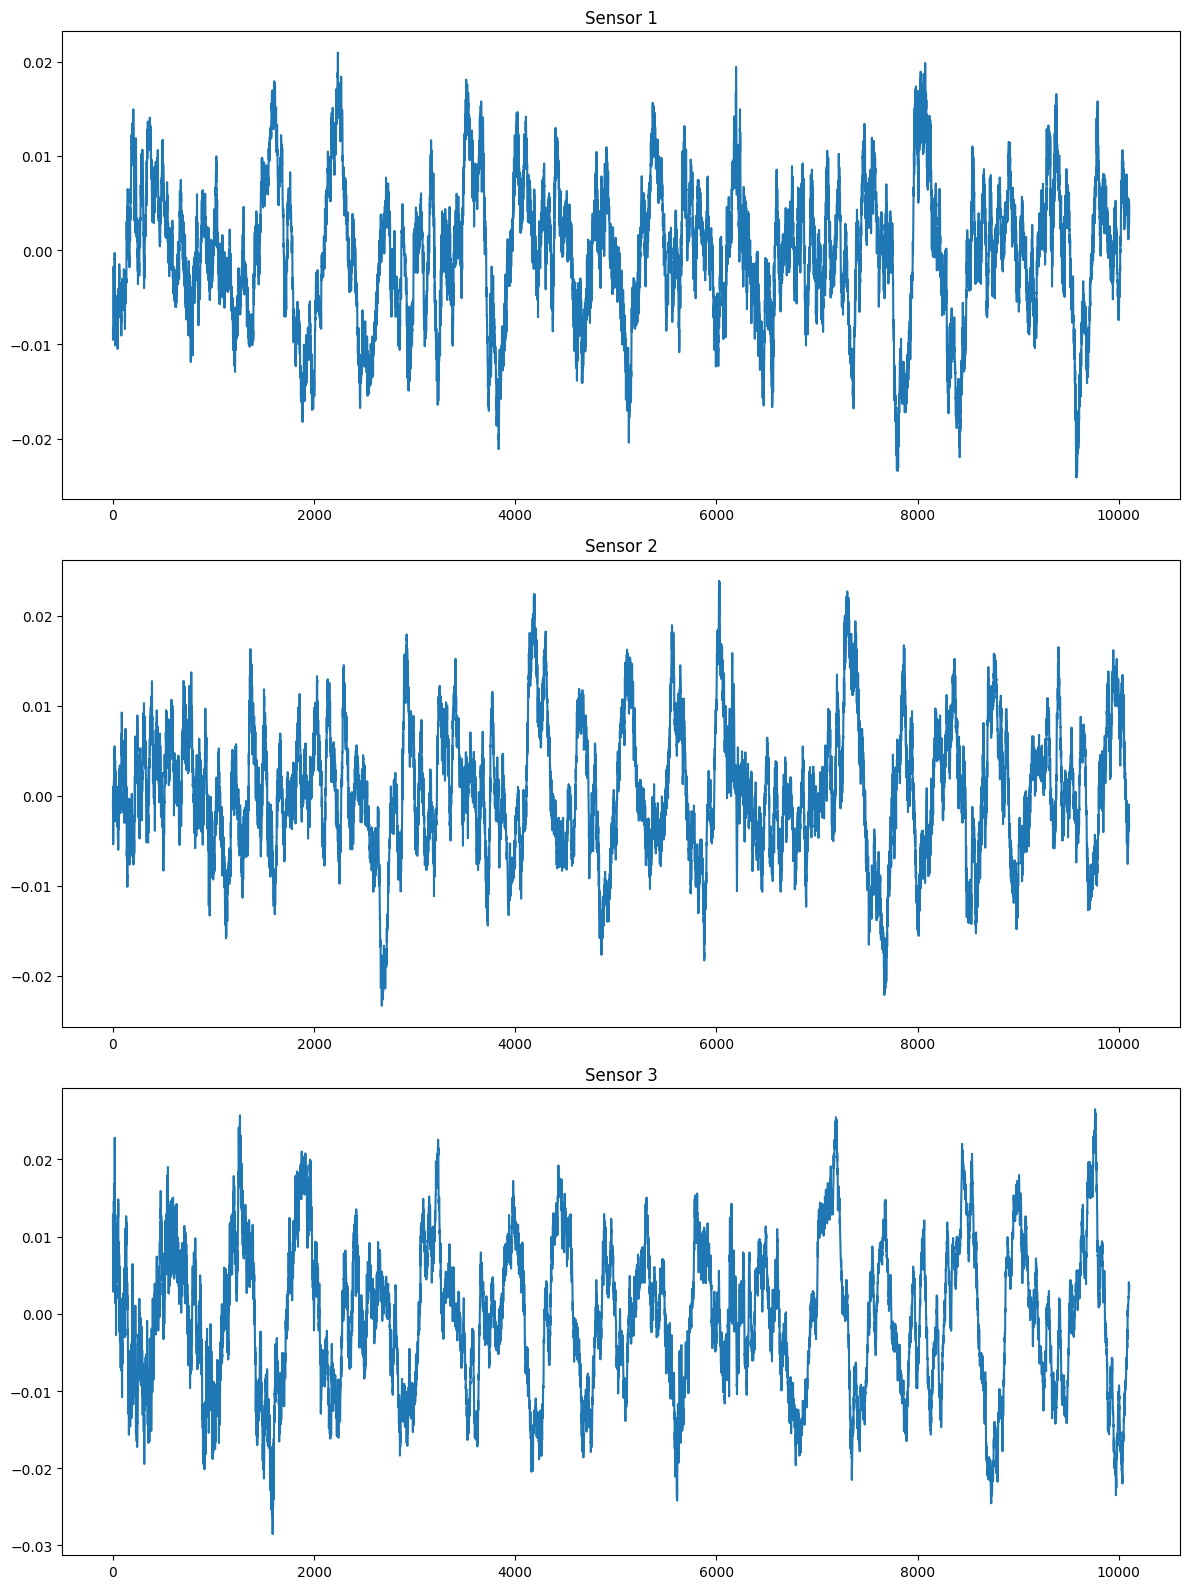

Text(0.5, 1.0, 'Sensor 1')

Text(0.5, 1.0, 'Sensor 2')

Text(0.5, 1.0, 'Sensor 3')

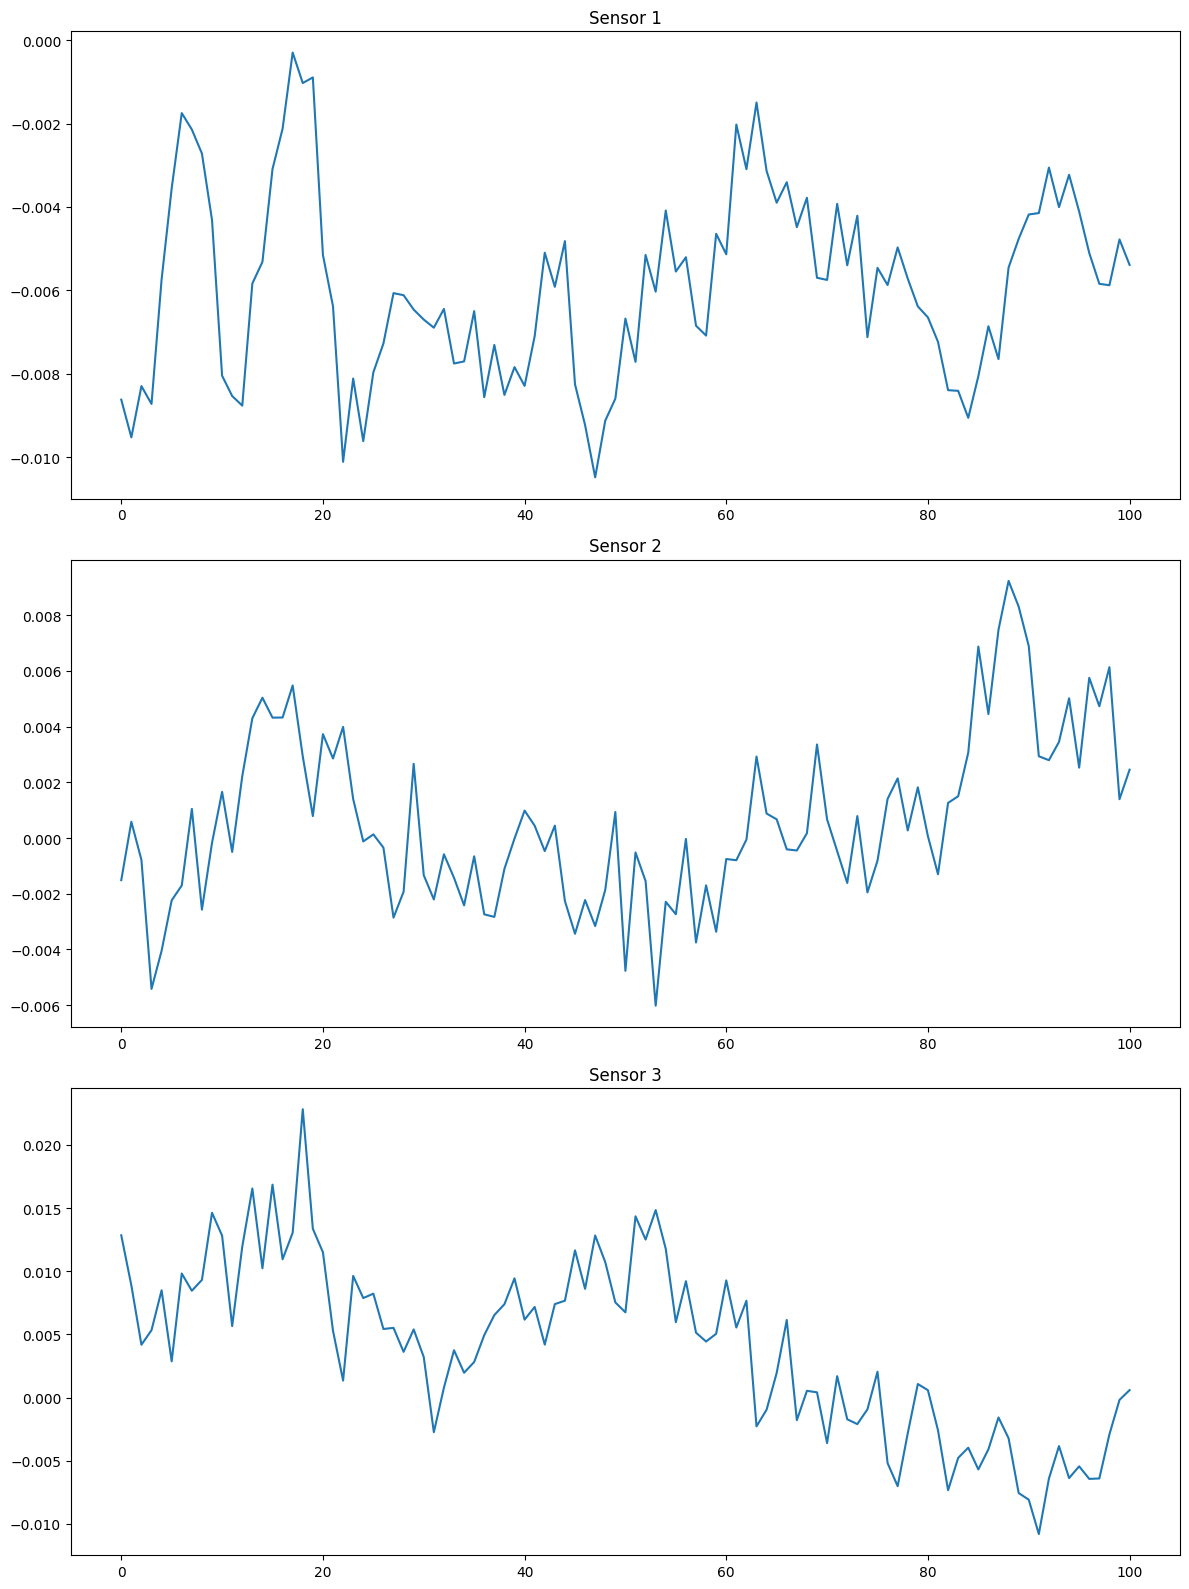

Sensor shape: (10104,)
Tập mẫu gốc: (10000, 100) (10000, 5)


'\n# ==== 9. Xáo trộn lại ====\nindices = np.arange(len(X_train))\nnp.random.shuffle(indices)\nX_train, y_train = X_train[indices], y_train[indices]\n'

Train: (7000, 100) (7000, 5)
Val: (1500, 100) (1500, 5)
Test: (1500, 100) (1500, 5)
Train dataset:
[-1.33134785e-03 -9.75787229e-04 -1.91317433e-03 -1.80522539e-03
 -8.92843413e-04 -1.78753884e-03 -5.73875650e-04 -2.01014540e-03
 -5.79163240e-05  1.39664986e-03  1.87255838e-04 -1.34293559e-03
 -1.07519783e-03 -4.43198286e-03 -2.09186946e-03 -5.37607864e-03
 -4.86011932e-03 -3.68975768e-03 -4.49724012e-03 -2.55598890e-03
 -5.85483523e-03 -3.32992789e-03 -6.37567360e-03 -3.88613936e-03
 -6.02560191e-03 -4.91134932e-03 -7.73143907e-03 -5.74566653e-03
 -8.75055022e-03 -7.65337430e-03 -6.67329553e-03 -7.64666561e-03
 -6.82637566e-03 -6.41897515e-03 -4.91378885e-03 -8.77494546e-03
 -5.42425924e-03 -7.72168097e-03 -5.47000032e-03 -6.57205528e-03
 -8.95242083e-03 -8.26996399e-03 -5.11017053e-03 -8.09553802e-03
 -4.18315141e-03 -6.11342477e-03 -4.63690287e-03 -4.52468477e-03
 -3.76416316e-03 -6.35554753e-03 -4.42588405e-03 -5.52184020e-03
 -5.06686898e-03 -1.93391028e-03 -3.71537268e-03 -4.6021

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ==== 1. Load và chuẩn hóa dữ liệu ====
# Giả sử `data` là mảng numpy có kích thước (1959737, 3)
# Transpose thành (3 x timesteps)
Data = np.transpose(final_array)  # 
print("Dữ liệu gốc:", Data.shape) # Dữ liệu gốc: (3, 1959737)

# ==== 2. Vẽ toàn bộ dữ liệu gốc ====
fig, axes = plt.subplots(3, 1, figsize=(12, 16))
for i in range(3):
    axes[i].plot(Data[i])
    axes[i].set_title(f'Sensor {i+1}')
plt.tight_layout()
plt.show()

# ==== 3. Cắt dữ liệu theo vùng quan tâm ====
Data = Data[:, 300000:600000]  # (3, 300.000)
print(Data.shape)

Data = Data[:, step_start:step_finish]   # step_start:step_finish xem cell đầu tiên của file.
print("Sau khi slice:", Data.shape)

# ==== 4. Vẽ dữ liệu vùng cắt ====
fig, axes = plt.subplots(3, 1, figsize=(12, 16))
for i in range(3):
    axes[i].plot(Data[i])
    axes[i].set_title(f'Sensor {i+1}')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(3, 1, figsize=(12, 16))
for i in range(3):
    axes[i].plot(Data[i][:101])  # Lấy từ timestep 0 đến 100
    axes[i].set_title(f'Sensor {i+1}')
plt.tight_layout()
plt.show()

# ==== 5. Chọn sensor cụ thể để làm việc (ví dụ sensor 1, 2 hoac 3) ====
Data1 = Data[select_sensor-1, :] 
print("Sensor shape:", Data1.shape)

# ==== 6. Hàm tạo sliding window ====
def create_sequences(data, input_steps, output_steps):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[i : i + input_steps])
        y.append(data[i + input_steps : i + input_steps + output_steps])
    return np.array(X), np.array(y)


X, y = create_sequences(Data1, input_steps, output_steps)

print("Tập mẫu gốc:", X.shape, y.shape)

# ==== 7. Chia train/val/test ====
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42) #random_state=42 --> data giống nhau.
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5,random_state=42) #

'''
# ==== 9. Xáo trộn lại ====
indices = np.arange(len(X_train))
np.random.shuffle(indices)
X_train, y_train = X_train[indices], y_train[indices]
'''

# ==== 10. In kết quả ====
print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)
print("Train dataset:")
print(X_train[0], y_train[0])
print("Validate dataset:")
print(X_val[0], y_val[0])
print("Test dataset:")
print(X_test[0], y_test[0])

# 4. Chuẩn hóa dữ liệu: phương pháp Min-Max Scaling

In [4]:
# Hàm scale_data(train_data, validate_data, test_data) được sử dụng để chuẩn hóa dữ liệu bằng phương pháp Min-Max Scaling.
# Chuẩn hóa giúp dữ liệu nằm trong một phạm vi nhất định (thường là từ 0 đến 1), làm cho mô hình học hiệu quả hơn.
# Chuẩn hóa dữ liệu (test_data) theo cùng thang đo với dữ liệu huấn luyện.
# Trả về dữ liệu đã chuẩn hóa.

max_scaler = np.max(Data1)
min_scaler = np.min(Data1)

print("max_scaler = " + str(max_scaler))
print("min_scaler = " + str(min_scaler))

print("Truoc khi chuan hoa: ")
print(X_train[0], y_train[0])
def scale_data(X_train, y_train, X_val, y_val, X_test, y_test):
    X_train_scaled = (X_train - min_scaler) / (max_scaler - min_scaler)
    y_train_scaled = (y_train - min_scaler) / (max_scaler - min_scaler)

    X_val_scaled = (X_val - min_scaler) / (max_scaler - min_scaler)
    y_val_scaled = (y_val - min_scaler) / (max_scaler - min_scaler)

    X_test_scaled = (X_test - min_scaler) / (max_scaler - min_scaler)
    y_test_scaled = (y_test - min_scaler) / (max_scaler - min_scaler)
 
    return X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled 

X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled  = scale_data(X_train, y_train, X_val, y_val, X_test, y_test)
print("Sau khi chuan hoa: ")
print(X_train_scaled[0], y_train_scaled[0])

# Lưu Min-Max Scaler để dùng lại khi predict (không cần chạy lại Model):
# Lưu vào file .npy với NumPy
np.save("scaler_values.npy", np.array([min_scaler, max_scaler]))
# Khi cần gọi lấy giá trị, Tải lại giá trị đã lưu
# min_scaler, max_scaler = np.load("scaler_values.npy")

max_scaler = 0.020975049723
min_scaler = -0.024115892131
Truoc khi chuan hoa: 
[-1.33134785e-03 -9.75787229e-04 -1.91317433e-03 -1.80522539e-03
 -8.92843413e-04 -1.78753884e-03 -5.73875650e-04 -2.01014540e-03
 -5.79163240e-05  1.39664986e-03  1.87255838e-04 -1.34293559e-03
 -1.07519783e-03 -4.43198286e-03 -2.09186946e-03 -5.37607864e-03
 -4.86011932e-03 -3.68975768e-03 -4.49724012e-03 -2.55598890e-03
 -5.85483523e-03 -3.32992789e-03 -6.37567360e-03 -3.88613936e-03
 -6.02560191e-03 -4.91134932e-03 -7.73143907e-03 -5.74566653e-03
 -8.75055022e-03 -7.65337430e-03 -6.67329553e-03 -7.64666561e-03
 -6.82637566e-03 -6.41897515e-03 -4.91378885e-03 -8.77494546e-03
 -5.42425924e-03 -7.72168097e-03 -5.47000032e-03 -6.57205528e-03
 -8.95242083e-03 -8.26996399e-03 -5.11017053e-03 -8.09553802e-03
 -4.18315141e-03 -6.11342477e-03 -4.63690287e-03 -4.52468477e-03
 -3.76416316e-03 -6.35554753e-03 -4.42588405e-03 -5.52184020e-03
 -5.06686898e-03 -1.93391028e-03 -3.71537268e-03 -4.60213965e-03
 -1.7979068

# 5. Reshape (samples, timesteps, features)

In [5]:
print("Ket qua truoc khi reshape:")
print("X_train_scaled: " + str(X_train_scaled.shape))
print("X_val_scaled: " + str(X_val_scaled.shape))
print("X_test_scaled: " + str(X_test_scaled.shape))
print("-------------------------------------------")
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], n_features))
X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], n_features))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], n_features))
print("Ket qua sau khi reshape:")
print("X_train_scaled: " + str(X_train_scaled.shape))
print("X_val_scaled: " + str(X_val_scaled.shape))
print("X_test_scaled: " + str(X_test_scaled.shape))

Ket qua truoc khi reshape:
X_train_scaled: (7000, 100)
X_val_scaled: (1500, 100)
X_test_scaled: (1500, 100)
-------------------------------------------
Ket qua sau khi reshape:
X_train_scaled: (7000, 100, 1)
X_val_scaled: (1500, 100, 1)
X_test_scaled: (1500, 100, 1)


# 6. Model setup and Train

## 6.1. Kiến trúc mô hình TCN dùng TensorFlow (input 125 bước → output 5 bước)

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Residual Block cho TCN
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, dilation_rate, dropout_rate=0.2):
        super().__init__()
        self.conv1 = layers.Conv1D(filters, kernel_size, padding='causal',
                                   dilation_rate=dilation_rate)
        self.relu1 = layers.Activation('relu')
        self.dropout1 = layers.Dropout(dropout_rate)

        self.conv2 = layers.Conv1D(filters, kernel_size, padding='causal',
                                   dilation_rate=dilation_rate)
        self.relu2 = layers.Activation('relu')
        self.dropout2 = layers.Dropout(dropout_rate)

        self.downsample = None
        self.final_relu = layers.Activation('relu')
        self.filters = filters

    def build(self, input_shape):
        in_channels = input_shape[-1]
        if in_channels != self.filters:
            self.downsample = layers.Conv1D(self.filters, kernel_size=1, padding='same')
        super().build(input_shape)

    def call(self, x, training=False):
        residual = x
        if self.downsample is not None:
            residual = self.downsample(x)

        x = self.conv1(x)
        x = self.relu1(x)
        x = self.dropout1(x, training=training)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.dropout2(x, training=training)

        return self.final_relu(x + residual)

# TCN Model
class TCN_Model(tf.keras.Model):
    def __init__(self, num_blocks=4, filters=64, kernel_size=3, target_len=5):
        super().__init__()

        self.tcn_blocks = tf.keras.Sequential()
        for i in range(num_blocks):
            dilation_rate = 2 ** i
            self.tcn_blocks.add(ResidualBlock(filters, kernel_size, dilation_rate))

        # Lấy bước thời gian cuối cùng
        self.last_time_step = layers.Lambda(lambda x: x[:, -1, :])  # shape (batch, features)

        # Fully connected layers
        self.fc1 = layers.Dense(128, activation='relu')
        self.fc2 = layers.Dense(64, activation='relu')
        self.out = layers.Dense(target_len)  # output sequence

    def call(self, x, training=False):
        x = self.tcn_blocks(x, training=training)  # (batch, time, filters)
        x = self.last_time_step(x)                 # (batch, filters)
        x = self.fc1(x)
        x = self.fc2(x)
        return self.out(x)                         # (batch, target_len)


## 6.2. Tạo tf.data.Dataset từ dữ liệu đã chuẩn hóa và reshape

In [7]:
batch_size = 64

train_ds = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_scaled)).shuffle(1000).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val_scaled)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test_scaled)).batch(batch_size)

## 6.3. Huấn luyện model Keras

In [8]:
import time
import pandas as pd
import tensorflow as tf

# Khởi tạo model TCN
model = TCN_Model(num_blocks=4, filters=64, kernel_size=3, target_len=output_steps)
model.build(input_shape=(None, input_steps, 1))
model.summary()

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    patience=20,
    restore_best_weights=True,
    monitor='val_loss'
)
csv_logger = tf.keras.callbacks.CSVLogger("training_log.csv", append=False)

# Đo thời gian huấn luyện
start_time = time.time()

# Fit model
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=1000,
    batch_size=64,
    callbacks=[early_stop, csv_logger],
    verbose=1
)

training_time = round(time.time() - start_time, 2)
print(f"✅ Huấn luyện hoàn tất sau {training_time} giây.")

# Lưu thời gian ra file
pd.DataFrame({"Training Time (s)": [training_time]}).to_csv("training_time.csv", index=False)


Model: "tcn__model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 100, 64)           86848     
                                                                 
 lambda (Lambda)             multiple                  0         
                                                                 
 dense (Dense)               multiple                  8320      
                                                                 
 dense_1 (Dense)             multiple                  8256      
                                                                 
 dense_2 (Dense)             multiple                  325       
                                                                 
Total params: 103,749
Trainable params: 103,749
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
110/110 [============================

# 7. Lưu Model

In [9]:
import pickle
import pandas as pd

# === 1. Lưu mô hình dưới dạng TensorFlow SavedModel (phù hợp với TF 2.10.1) ===
model.save("model_saved", save_format="tf")  # Lưu dưới dạng thư mục
print("✅ Đã lưu model tại thư mục model_saved/")

# === 2. Lưu lịch sử huấn luyện (history) bằng pickle để dùng vẽ biểu đồ sau ===
with open("history_saved.pkl", "wb") as f:
    pickle.dump(history.history, f)
print("✅ Đã lưu history tại history_saved.pkl")

# === 3. Lưu log huấn luyện thành CSV (phân tích/trực quan bằng Excel/Pandas) ===
df = pd.DataFrame({
    "Epoch": list(range(1, len(history.history['loss']) + 1)),
    "Train Loss": history.history['loss'],
    "Train MAE": history.history['mean_absolute_error'],
    "Val Loss": history.history['val_loss'],
    "Val MAE": history.history['val_mean_absolute_error'],
})
df.to_csv("training_log.csv", index=False)
print("✅ Đã lưu training log tại training_log.csv")


INFO:tensorflow:Assets written to: model_saved\assets


INFO:tensorflow:Assets written to: model_saved\assets


✅ Đã lưu model tại thư mục model_saved/
✅ Đã lưu history tại history_saved.pkl
✅ Đã lưu training log tại training_log.csv


# 8. Vẽ biểu đồ loss

## 8.1. Matplotlib

<Figure size 1000x500 with 0 Axes>

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss (MSE)')

Text(0.5, 1.0, 'Training and Validation MSE Loss')

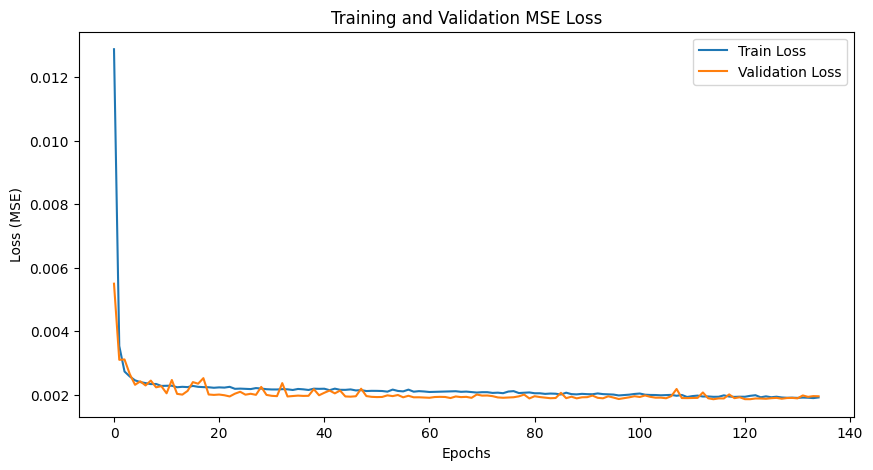

<Figure size 1000x500 with 0 Axes>

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'MAE')

Text(0.5, 1.0, 'Training and Validation MAE')

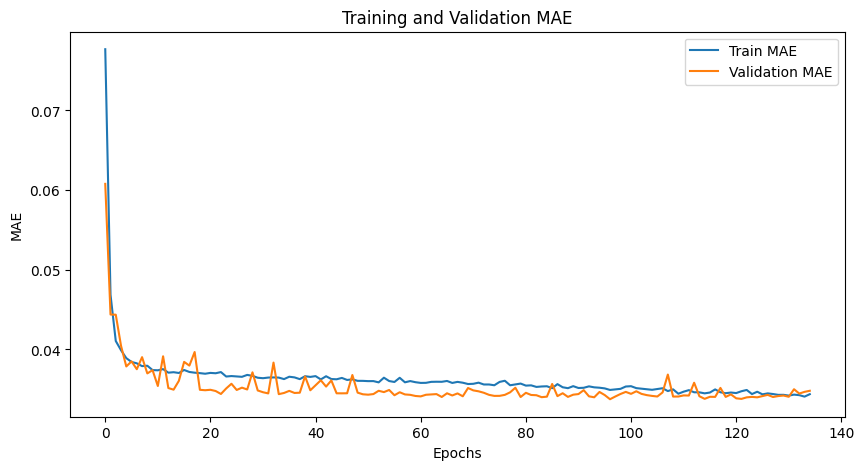

In [10]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ Loss MSE
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation MSE Loss')
plt.legend()
plt.show()

# Vẽ biểu đồ MAE
plt.figure(figsize=(10, 5))
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

# 9. Evaluation

In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Đánh giá mô hình trên tập test (evaluate)
test_metrics = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f"Test metrics (loss + metrics): {test_metrics}")

# 2. Dự đoán trên train, val, test
y_train_pred_scaled = model.predict(X_train_scaled)
y_val_pred_scaled = model.predict(X_val_scaled)
y_test_pred_scaled = model.predict(X_test_scaled)

# Chuyển về dạng 2D (n_samples, out_steps) nếu cần
y_train_real = y_train_scaled.squeeze() * (max_scaler - min_scaler) + min_scaler
y_val_real = y_val_scaled.squeeze() * (max_scaler - min_scaler) + min_scaler
y_test_real = y_test_scaled.squeeze() * (max_scaler - min_scaler) + min_scaler

y_train_pred = y_train_pred_scaled.squeeze() * (max_scaler - min_scaler) + min_scaler
y_val_pred = y_val_pred_scaled.squeeze() * (max_scaler - min_scaler) + min_scaler
y_test_pred = y_test_pred_scaled.squeeze() * (max_scaler - min_scaler) + min_scaler

print("Average value of train data = " + str(np.mean(y_train_real)))
print("Average value of val data = " + str(np.mean(y_val_real))) 
print("Average value of test data = " + str(np.mean(y_test_real)))

# Tính các chỉ số
def calc_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

rmse_train, mae_train, r2_train = calc_metrics(y_train_real, y_train_pred)
rmse_val, mae_val, r2_val = calc_metrics(y_val_real, y_val_pred)
rmse_test, mae_test, r2_test = calc_metrics(y_test_real, y_test_pred)

print("Đánh giá mô hình:")
print(f"Train    - RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}")
print(f"Validate - RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, R²: {r2_val:.4f}")
print(f"Test     - RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}")

# Lưu kết quả đánh giá mô hình
metrics_df = pd.DataFrame({
    "Dataset": ["Train", "Validation", "Test"],
    "RMSE": [rmse_train, rmse_val, rmse_test],
    "MAE": [mae_train, mae_val, mae_test],
    "R2": [r2_train, r2_val, r2_test]
})

metrics_df.to_csv("metrics.csv", index=False)
print("Metrics saved to metrics.csv")


Test metrics (loss + metrics): [0.001985134556889534, 0.03484291955828667]
47/47 [==============================] - 0s 7ms/step
Average value of train data = -0.0003532481662701714
Average value of val data = -5.31140396885333e-05
Average value of test data = -7.218721413013333e-05
Đánh giá mô hình:
Train    - RMSE: 0.0019, MAE: 0.0015, R²: 0.9314
Validate - RMSE: 0.0019, MAE: 0.0015, R²: 0.9279
Test     - RMSE: 0.0020, MAE: 0.0016, R²: 0.9255
Metrics saved to metrics.csv


In [12]:
'''
import numpy as np
# 1. Đánh giá mô hình trên tập test (evaluate)
test_loss = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f'Test Loss: {test_loss}')

# 2. Đánh giá hiệu suất bằng các chỉ số (RMSE, MAE, R²)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Dự đoán trên tập train, validate, test
y_train_pred_scaled = model.predict(X_train_scaled)
y_val_pred_scaled = model.predict(X_val_scaled)
y_test_pred_scaled = model.predict(X_test_scaled)

# MinMaxScaler trả về giá trị thật để đánh giá: Xreal = X'*(Max - Min) + Min
y_train_real = y_train_scaled * (max_scaler - min_scaler) + min_scaler
y_val_real = y_val_scaled * (max_scaler - min_scaler) + min_scaler
y_test_real = y_test_scaled * (max_scaler - min_scaler) + min_scaler
print("Average value of train data = " + str(np.mean(y_train_real)))
print("Average value of val data = " + str(np.mean(y_val_real))) 
print("Average value of test data = " + str(np.mean(y_test_real)))
y_train_pred = y_train_pred_scaled * (max_scaler - min_scaler) + min_scaler
y_val_pred = y_val_pred_scaled * (max_scaler - min_scaler) + min_scaler
y_test_pred = y_test_pred_scaled * (max_scaler - min_scaler) + min_scaler

# Tính chỉ số cho tập train
rmse_train = np.sqrt(mean_squared_error(y_train_real, y_train_pred))
mae_train = mean_absolute_error(y_train_real, y_train_pred)
r2_train = r2_score(y_train_real, y_train_pred)

# Tính chỉ số cho tập validate
rmse_val = np.sqrt(mean_squared_error(y_val_real, y_val_pred))
mae_val = mean_absolute_error(y_val_real, y_val_pred)
r2_val = r2_score(y_val_real, y_val_pred)

# Tính chỉ số cho tập test
rmse_test = np.sqrt(mean_squared_error(y_test_real, y_test_pred))
mae_test = mean_absolute_error(y_test_real, y_test_pred)
r2_test = r2_score(y_test_real, y_test_pred)
# R² = 1: Mô hình hoàn hảo. R² > 0.9: Mô hình tốt. R² < 0.5: Mô hình chưa tốt, cần cải thiện.

# In kết quả
print("Đánh giá mô hình:")
print(f"Train   - RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}")
print(f"Validate- RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, R²: {r2_val:.4f}")
print(f"Test    - RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}")

# Lưu kết quả đánh giá mô hình Train, Validate và Test thành file *csv mở như excel
import pandas as pd
# Tạo DataFrame chứa các chỉ số
metrics_df = pd.DataFrame({
    "Dataset": ["Train", "Validation", "Test"],
    "RMSE": [rmse_train, rmse_val, rmse_test],
    "MAE": [mae_train, mae_val, mae_test],
    "R2": [r2_train, r2_val, r2_test]
})
# Lưu vào file CSV
metrics_df.to_csv("metrics.csv", index=False)
print("Metrics saved to metrics.csv")
'''

'\nimport numpy as np\n# 1. Đánh giá mô hình trên tập test (evaluate)\ntest_loss = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)\nprint(f\'Test Loss: {test_loss}\')\n\n# 2. Đánh giá hiệu suất bằng các chỉ số (RMSE, MAE, R²)\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score\nimport numpy as np\n\n# Dự đoán trên tập train, validate, test\ny_train_pred_scaled = model.predict(X_train_scaled)\ny_val_pred_scaled = model.predict(X_val_scaled)\ny_test_pred_scaled = model.predict(X_test_scaled)\n\n# MinMaxScaler trả về giá trị thật để đánh giá: Xreal = X\'*(Max - Min) + Min\ny_train_real = y_train_scaled * (max_scaler - min_scaler) + min_scaler\ny_val_real = y_val_scaled * (max_scaler - min_scaler) + min_scaler\ny_test_real = y_test_scaled * (max_scaler - min_scaler) + min_scaler\nprint("Average value of train data = " + str(np.mean(y_train_real)))\nprint("Average value of val data = " + str(np.mean(y_val_real))) \nprint("Average value of test data = " + s

# 10. Vẽ biểu đồ giữa giá trị thực tế và dự đoán cho một số test samples.

In [13]:
'''
num_samples = 10  # Số lượng sample cần vẽ

# Vẽ biểu đồ cho 10 sample
for i in range(num_samples):
    # Lấy dữ liệu đầu vào của sample thứ i
    sample_input = X_test_scaled[i].reshape(1, X_test_scaled.shape[1], n_features)  # Reshape thành (1, n_steps, n_features)

    # Dự đoán kết quả
    predicted_value = model.predict(sample_input)

    print("Shape of y_test_scaled[i]:", y_test_scaled[i].shape)
    print("Shape of predicted_value:", predicted_value.shape)
    print("Shape of predicted_value[0]:", predicted_value[0].shape)

    # Vẽ biểu đồ so sánh
    plt.figure(figsize=(8, 4))  # Tạo figure mới để không bị chồng lấn
    plt.plot(range(len(y_test_scaled[i])), y_test_scaled[i]*(max_scaler - min_scaler) + min_scaler, marker='o', label="Actual", color='blue')
    plt.plot(range(len(predicted_value[0])), predicted_value[0]*(max_scaler - min_scaler) + min_scaler, marker='D', label="Predicted", color='red', linestyle="dashed")

    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.title(f"Prediction for Sample {i}")


    plt.show()
'''

'\nnum_samples = 10  # Số lượng sample cần vẽ\n\n# Vẽ biểu đồ cho 10 sample\nfor i in range(num_samples):\n    # Lấy dữ liệu đầu vào của sample thứ i\n    sample_input = X_test_scaled[i].reshape(1, X_test_scaled.shape[1], n_features)  # Reshape thành (1, n_steps, n_features)\n\n    # Dự đoán kết quả\n    predicted_value = model.predict(sample_input)\n\n    print("Shape of y_test_scaled[i]:", y_test_scaled[i].shape)\n    print("Shape of predicted_value:", predicted_value.shape)\n    print("Shape of predicted_value[0]:", predicted_value[0].shape)\n\n    # Vẽ biểu đồ so sánh\n    plt.figure(figsize=(8, 4))  # Tạo figure mới để không bị chồng lấn\n    plt.plot(range(len(y_test_scaled[i])), y_test_scaled[i]*(max_scaler - min_scaler) + min_scaler, marker=\'o\', label="Actual", color=\'blue\')\n    plt.plot(range(len(predicted_value[0])), predicted_value[0]*(max_scaler - min_scaler) + min_scaler, marker=\'D\', label="Predicted", color=\'red\', linestyle="dashed")\n\n    plt.xlabel("Time Step"

In [14]:
'''
import matplotlib.pyplot as plt
import numpy as np

num_samples = 10  # Số lượng sample cần vẽ
n_steps = X_test_scaled.shape[1]  # Số bước thời gian trong đầu vào

# Vẽ biểu đồ cho từng sample
for i in range(num_samples):
    # Lấy dữ liệu đầu vào
    sample_input = X_test_scaled[i].reshape(1, X_test_scaled.shape[1], X_test_scaled.shape[2])  # Reshape để phù hợp mô hình

    # Dự đoán chuỗi thời gian tương lai
    predicted_value = model.predict(sample_input)[0]  # Lấy mảng kết quả từ dự đoán

    # Tạo trục thời gian
    time_input = np.arange(n_steps)  # Trục thời gian cho dữ liệu đầu vào
    time_future = np.arange(n_steps, n_steps + len(predicted_value))  # Trục thời gian cho dự đoán

    # Vẽ biểu đồ
    plt.figure(figsize=(16, 4))

    # Vẽ dữ liệu quá khứ (testX)
    plt.plot(time_input, X_test_scaled[i][:, 0]*(max_scaler - min_scaler) + min_scaler, marker='s', label="Past Data (testX)", color='green')

    # Vẽ dữ liệu thực tế (testY)
    plt.plot(time_future, y_test_scaled[i]*(max_scaler - min_scaler) + min_scaler, marker='o', label="Actual Future (testY)", color='blue')

    # Vẽ dữ liệu dự báo (Predicted)
    plt.plot(time_future, predicted_value*(max_scaler - min_scaler) + min_scaler, marker='D', label="Predicted Future", color='red', linestyle='dashed')

    # Nối điểm cuối của past data với actual future
    plt.plot([n_steps - 1, n_steps], [X_test_scaled[i][-1, 0]*(max_scaler - min_scaler) + min_scaler, y_test_scaled[i][0]*(max_scaler - min_scaler) + min_scaler], color='blue')

    # Nối điểm cuối của past data với predicted future
    plt.plot([n_steps - 1, n_steps], [X_test_scaled[i][-1, 0]*(max_scaler - min_scaler) + min_scaler, predicted_value[0]*(max_scaler - min_scaler) + min_scaler], color='red', linestyle='dashed')

    # Thêm đường kẻ ngang qua y = 0
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.title(f"Time Series Prediction for Sample {i}")
    plt.grid(which='both')  # Hiển thị cả major và minor grid

    plt.show()
'''

'\nimport matplotlib.pyplot as plt\nimport numpy as np\n\nnum_samples = 10  # Số lượng sample cần vẽ\nn_steps = X_test_scaled.shape[1]  # Số bước thời gian trong đầu vào\n\n# Vẽ biểu đồ cho từng sample\nfor i in range(num_samples):\n    # Lấy dữ liệu đầu vào\n    sample_input = X_test_scaled[i].reshape(1, X_test_scaled.shape[1], X_test_scaled.shape[2])  # Reshape để phù hợp mô hình\n\n    # Dự đoán chuỗi thời gian tương lai\n    predicted_value = model.predict(sample_input)[0]  # Lấy mảng kết quả từ dự đoán\n\n    # Tạo trục thời gian\n    time_input = np.arange(n_steps)  # Trục thời gian cho dữ liệu đầu vào\n    time_future = np.arange(n_steps, n_steps + len(predicted_value))  # Trục thời gian cho dự đoán\n\n    # Vẽ biểu đồ\n    plt.figure(figsize=(16, 4))\n\n    # Vẽ dữ liệu quá khứ (testX)\n    plt.plot(time_input, X_test_scaled[i][:, 0]*(max_scaler - min_scaler) + min_scaler, marker=\'s\', label="Past Data (testX)", color=\'green\')\n\n    # Vẽ dữ liệu thực tế (testY)\n    plt.plo

# 11. Gọi lại History:

In [15]:
'''
import pickle

with open('history_saved.pkl', 'rb') as f:
    history = pickle.load(f)

print(history.keys())  # Kiểm tra các giá trị được lưu
print(history['loss'])  # In train loss
print(history['val_loss'])  # In validation loss

# Vẽ biểu đồ loss MSE
plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Kiểm tra xem MAE có được lưu không
if 'mae' in history and 'val_mae' in history:
    # Vẽ biểu đồ MAE
    plt.figure(figsize=(10, 5))
    plt.plot(history['mae'], label='Train MAE')
    plt.plot(history['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Training and Validation MAE')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Không tìm thấy MAE trong history!")
'''

'\nimport pickle\n\nwith open(\'history_saved.pkl\', \'rb\') as f:\n    history = pickle.load(f)\n\nprint(history.keys())  # Kiểm tra các giá trị được lưu\nprint(history[\'loss\'])  # In train loss\nprint(history[\'val_loss\'])  # In validation loss\n\n# Vẽ biểu đồ loss MSE\nplt.figure(figsize=(10, 5))\nplt.plot(history[\'loss\'], label=\'Train Loss\')\nplt.plot(history[\'val_loss\'], label=\'Validation Loss\')\nplt.xlabel(\'Epochs\')\nplt.ylabel(\'Loss\')\nplt.title(\'Training and Validation Loss\')\nplt.legend()\nplt.grid(True)\nplt.show()\n\n# Kiểm tra xem MAE có được lưu không\nif \'mae\' in history and \'val_mae\' in history:\n    # Vẽ biểu đồ MAE\n    plt.figure(figsize=(10, 5))\n    plt.plot(history[\'mae\'], label=\'Train MAE\')\n    plt.plot(history[\'val_mae\'], label=\'Validation MAE\')\n    plt.xlabel(\'Epochs\')\n    plt.ylabel(\'Mean Absolute Error (MAE)\')\n    plt.title(\'Training and Validation MAE\')\n    plt.legend()\n    plt.grid(True)\n    plt.show()\nelse:\n    pr

# 12. Gọi lại Model và Predict

### 12.1. Recall Model

In [16]:
'''
# Load lại mô hình
import tensorflow as tf
model = tf.keras.models.load_model("model_saved.keras")
'''

'\n# Load lại mô hình\nimport tensorflow as tf\nmodel = tf.keras.models.load_model("model_saved.keras")\n'

### 12.2. Preparation for Prediction Data

In [17]:
'''
# Dữ liệu ban đầu chưa chuẩn hóa là Data1
import numpy as np

# Số lượng mẫu và độ dài mỗi đoạn
num_samples = 20
time_steps = 255 # 125 + 5 + 125

# Chọn vị trí ngẫu nhiên để lấy đoạn dữ liệu, đảm bảo không vượt quá giới hạn
start_indices = np.random.randint(0, 10000 - time_steps, num_samples)

# Lấy các đoạn dữ liệu
samples = np.array([Data1[i:i + time_steps] for i in start_indices])

# Kết quả có shape (20, 105)
print(samples.shape)  # (20, 105)

# Lấy 50 time steps đầu tiên từ mỗi sample
X = samples[:, :125]

# Kiểm tra shape của X
print(X.shape)  # (20, 50)

# Tải lại giá trị đã lưu của min_scaler, max_scaler
min_scaler, max_scaler = np.load("scaler_values.npy")

# Tránh chia cho 0 nếu max == min
denom = max_scaler - min_scaler
if denom == 0:
    denom = 1  # Tránh lỗi chia 0
# Chuẩn hóa X

X_normalized = (X - min_scaler) / denom
# Kiểm tra shape
print("X_normalized.shape = " + str(X_normalized.shape))

# Reshape X_normalized để thêm chiều features
X_input = X_normalized.reshape((X_normalized.shape[0], X_normalized.shape[1], 1))

# Kiểm tra shape mới
print(X_input.shape)  # (20, 50, 1)
'''

'\n# Dữ liệu ban đầu chưa chuẩn hóa là Data1\nimport numpy as np\n\n# Số lượng mẫu và độ dài mỗi đoạn\nnum_samples = 20\ntime_steps = 255 # 125 + 5 + 125\n\n# Chọn vị trí ngẫu nhiên để lấy đoạn dữ liệu, đảm bảo không vượt quá giới hạn\nstart_indices = np.random.randint(0, 10000 - time_steps, num_samples)\n\n# Lấy các đoạn dữ liệu\nsamples = np.array([Data1[i:i + time_steps] for i in start_indices])\n\n# Kết quả có shape (20, 105)\nprint(samples.shape)  # (20, 105)\n\n# Lấy 50 time steps đầu tiên từ mỗi sample\nX = samples[:, :125]\n\n# Kiểm tra shape của X\nprint(X.shape)  # (20, 50)\n\n# Tải lại giá trị đã lưu của min_scaler, max_scaler\nmin_scaler, max_scaler = np.load("scaler_values.npy")\n\n# Tránh chia cho 0 nếu max == min\ndenom = max_scaler - min_scaler\nif denom == 0:\n    denom = 1  # Tránh lỗi chia 0\n# Chuẩn hóa X\n\nX_normalized = (X - min_scaler) / denom\n# Kiểm tra shape\nprint("X_normalized.shape = " + str(X_normalized.shape))\n\n# Reshape X_normalized để thêm chiều feat

### 12.3. Prediction

In [18]:
'''
y_pred = model.predict(X_input)
# Kiểm tra output
print(y_pred.shape)  # Kiểm tra kích thước đầu ra của mô hình

# Đảo ngược chuẩn hóa y_pred để lấy giá trị thực
y_pred_real = y_pred * (max_scaler - min_scaler) + min_scaler
# Kiểm tra shape
print(y_pred_real.shape)  # (20, 5)
'''

'\ny_pred = model.predict(X_input)\n# Kiểm tra output\nprint(y_pred.shape)  # Kiểm tra kích thước đầu ra của mô hình\n\n# Đảo ngược chuẩn hóa y_pred để lấy giá trị thực\ny_pred_real = y_pred * (max_scaler - min_scaler) + min_scaler\n# Kiểm tra shape\nprint(y_pred_real.shape)  # (20, 5)\n'